In [154]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
import numpy as np
import pandas as pd
import datetime as dt
import config as cfg

from sqlalchemy import create_engine
import psycopg2

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Import Data from Postgre

In [156]:
# import data from AWS RDS Database


conn_string = "host="+cfg.PGHOST +" port="+ "5432" +" dbname="+ cfg.PGDATABASE +" user=" + cfg.PGUSER \
                  +" password="+ cfg.PGPASSWORD
    
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

df = pd.read_sql_query('select * from weather_aus_raw where year >=2011 and year <= 2016',  conn)
df_copy = df.copy
df.head()

date location  mintemp  maxtemp  rainfall  evaporation  sunshine  \
0  2011-01-01   Albury     23.2     35.8       0.0       9999.0    9999.0   
1  2011-01-02   Albury     20.1     31.1       0.6       9999.0    9999.0   
2  2011-01-03   Albury     13.6     29.4       0.0       9999.0    9999.0   
3  2011-01-04   Albury     13.9     29.2       0.0       9999.0    9999.0   
4  2011-01-05   Albury     16.0     28.9       0.0       9999.0    9999.0   

  windgustdir  windgustspeed winddir9am  ... pressure3pm  cloud9am  cloud3pm  \
0         ENE           26.0          S  ...      1009.2    9999.0    9999.0   
1           W           35.0         SW  ...      1009.5    9999.0    9999.0   
2         WNW           35.0        SSE  ...      1009.3    9999.0    9999.0   
3         SSE           24.0         SE  ...      1007.8    9999.0    9999.0   
4         SSE           31.0        ENE  ...      1004.3    9999.0    9999.0   

   temp9am  temp3pm  raintoday  raintomorrow  year  month  day  
0     26.8     32.8         No            No  2011      1    1  
1     25.1     30.2         No            No  2011      1    2  
2     20.2     28.4         No            No  2011      1    3  
3     19.9     27.9         No            No  2011      1    4  
4     22.0     26.8         No            No  2011      1    5  

[5 rows x 26 columns]

## Data Analysis

In [157]:
df.shape

(100935, 26)

In [158]:
# Check Datatypes

df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday         object
raintomorrow      object
year               int64
month              int64
day                int64
dtype: object

In [159]:
df.isna().count()

date             100935
location         100935
mintemp          100935
maxtemp          100935
rainfall         100935
evaporation      100935
sunshine         100935
windgustdir      100935
windgustspeed    100935
winddir9am       100935
winddir3pm       100935
windspeed9am     100935
windspeed3pm     100935
humidity9am      100935
humidity3pm      100935
pressure9am      100935
pressure3pm      100935
cloud9am         100935
cloud3pm         100935
temp9am          100935
temp3pm          100935
raintoday        100935
raintomorrow     100935
year             100935
month            100935
day              100935
dtype: int64

In [160]:
df['location'].nunique()

49

In [161]:
#df =  df.replace(['9999'],np.nan)
#df.head()

In [163]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Rainy Days' ,color ='raintoday')

In [164]:
import plotly.express as px
px.histogram(df , x = 'location' , title ='Location vs. Expected Rainy Days' ,color ='raintomorrow')

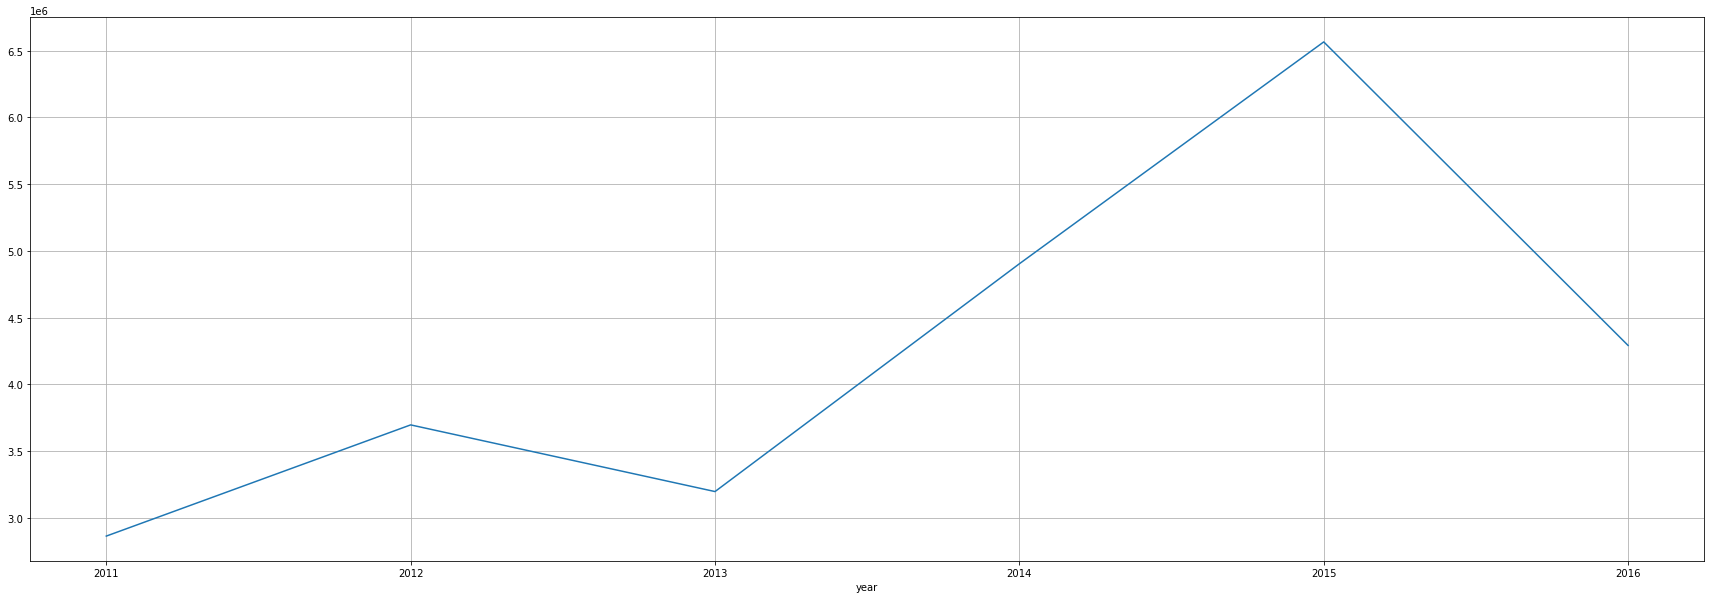

In [165]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
df.groupby('year')['rainfall'].sum().plot(grid=True)
plt.show()


## Check for Bucketing/Binning
#### we will skip binning for this dataset

In [166]:
# Check the unique value counts to see if binning is required
df.year.value_counts()

# Check the unique value counts to see if binning is required
#df.location.value_counts()

2016    17934
2014    17885
2015    17885
2013    16415
2012    15409
2011    15407
Name: year, dtype: int64

## Update "RainTomorrow" and "RainToday" Columns to Binary Values

In [167]:
df['raintomorrow'].value_counts()

No      76426
Yes     21980
9999     2529
Name: raintomorrow, dtype: int64

In [168]:
df['raintoday'].value_counts()

No      76427
Yes     21979
9999     2529
Name: raintoday, dtype: int64

In [169]:
df['raintomorrow'] = df.raintomorrow.eq('Yes').mul(1)
df['raintomorrow'] = df['raintomorrow'].astype(int)
df['raintomorrow'].value_counts()

0    78955
1    21980
Name: raintomorrow, dtype: int64

In [170]:
df['raintoday'] = df.raintoday.eq('Yes').mul(1)
df['raintoday'] = df['raintoday'].astype(int)
df['raintoday'].value_counts()

0    78956
1    21979
Name: raintoday, dtype: int64

In [171]:
df.dtypes

date              object
location          object
mintemp          float64
maxtemp          float64
rainfall         float64
evaporation      float64
sunshine         float64
windgustdir       object
windgustspeed    float64
winddir9am        object
winddir3pm        object
windspeed9am     float64
windspeed3pm     float64
humidity9am      float64
humidity3pm      float64
pressure9am      float64
pressure3pm      float64
cloud9am         float64
cloud3pm         float64
temp9am          float64
temp3pm          float64
raintoday          int32
raintomorrow       int32
year               int64
month              int64
day                int64
dtype: object

<AxesSubplot:xlabel='month', ylabel='raintoday'>

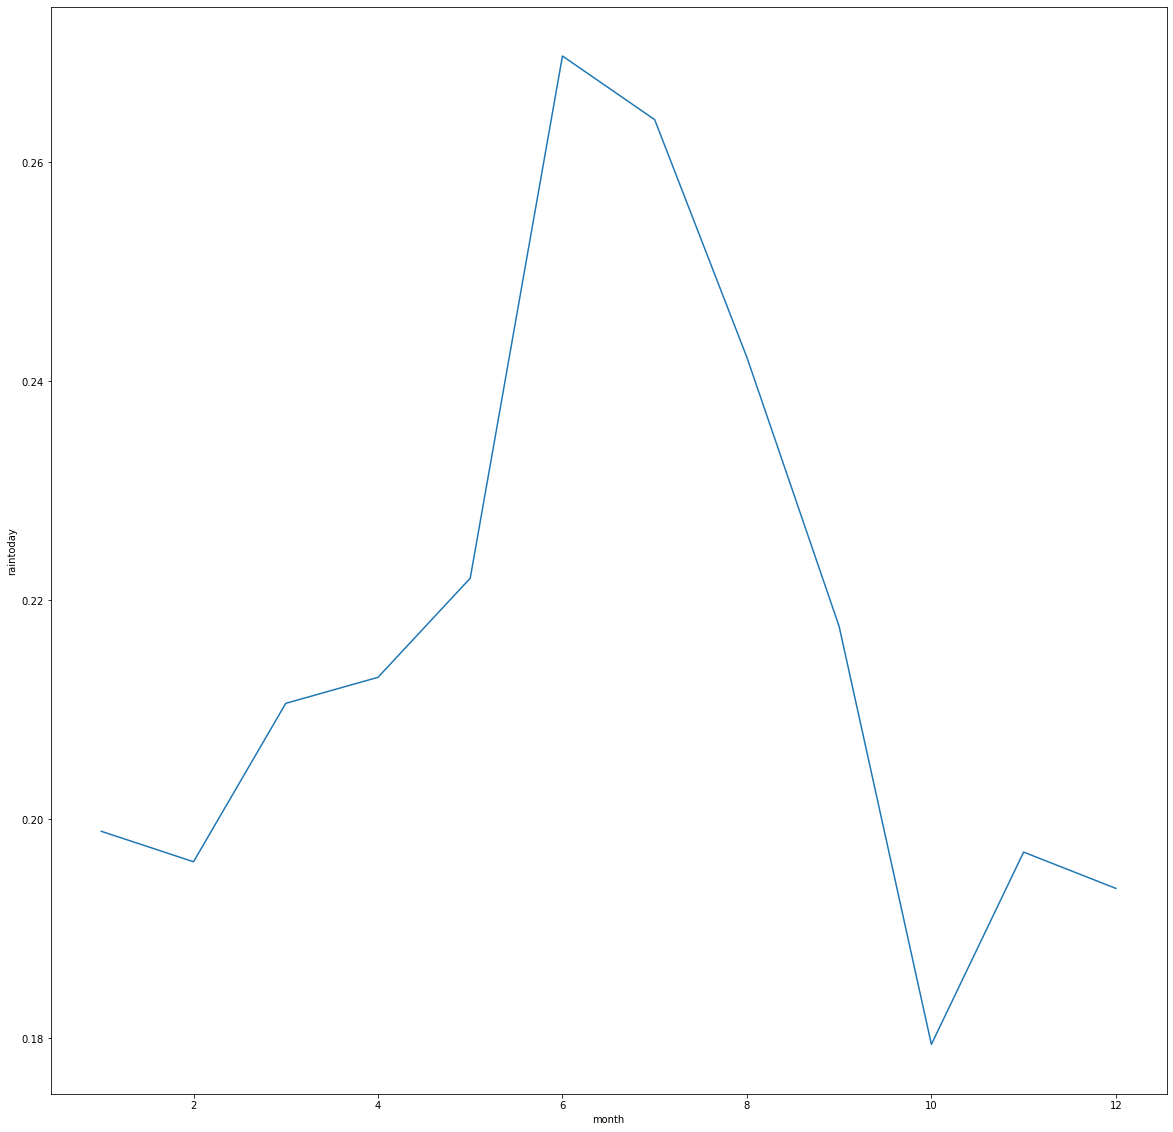

In [173]:
import seaborn as sns
df_grouped = df.groupby('month').mean()
df_grouped[['raintoday']]
sns.lineplot(data=df_grouped, x=df_grouped.index, y='raintoday')

#plt.title('Seasonality of Rainfall')
#plt.xlabel('Month of the Year')
#plt.ylabel('Percentage of Days it Rains')
#plt.tight_layout();

## Drop Columns Unnecessary for Machine Learning Model

In [176]:
# Drop the null columns where all values are null
#df = df.dropna(axis='columns', how='all')

# Drop the null rows
#df = df.dropna()

num_cols = df.select_dtypes('float64').columns.to_list()
print('float columns: ', num_cols)

for col in num_cols:
    df[col].replace(9999, df[col].mean(),inplace=True)    

df


columns =  ['date', 'location'] #, 'evaporation', 'windgustdir', 'winddir3pm', 'winddir9am']
df = df.drop(columns, axis=1)

float columns:  ['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm', 'temp9am', 'temp3pm']


In [178]:
print(df.shape)
df.head()

(100935, 24)


mintemp  maxtemp  rainfall  evaporation     sunshine windgustdir  \
0     23.2     35.8       0.0  4466.787138  5031.664498         ENE   
1     20.1     31.1       0.6  4466.787138  5031.664498           W   
2     13.6     29.4       0.0  4466.787138  5031.664498         WNW   
3     13.9     29.2       0.0  4466.787138  5031.664498         SSE   
4     16.0     28.9       0.0  4466.787138  5031.664498         SSE   

   windgustspeed winddir9am winddir3pm  windspeed9am  ...  pressure3pm  \
0           26.0          S        WSW          13.0  ...       1009.2   
1           35.0         SW        WSW           2.0  ...       1009.5   
2           35.0        SSE        WNW          19.0  ...       1009.3   
3           24.0         SE         SE          11.0  ...       1007.8   
4           31.0        ENE         SW           4.0  ...       1004.3   

      cloud9am     cloud3pm  temp9am  temp3pm  raintoday  raintomorrow  year  \
0  4002.574528  4239.462109     26.8     32.8          0             0  2011   
1  4002.574528  4239.462109     25.1     30.2          0             0  2011   
2  4002.574528  4239.462109     20.2     28.4          0             0  2011   
3  4002.574528  4239.462109     19.9     27.9          0             0  2011   
4  4002.574528  4239.462109     22.0     26.8          0             0  2011   

   month  day  
0      1    1  
1      1    2  
2      1    3  
3      1    4  
4      1    5  

[5 rows x 24 columns]

## Encode Columns - Use OneHotEncoder

In [179]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()
df_cat

['windgustdir', 'winddir9am', 'winddir3pm']

In [180]:
df[df_cat].nunique()

windgustdir    17
winddir9am     17
winddir3pm     17
dtype: int64

In [181]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(df[df_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(df_cat)
encode_df.head()


windgustdir_9999  windgustdir_E  windgustdir_ENE  windgustdir_ESE  \
0               0.0            0.0              1.0              0.0   
1               0.0            0.0              0.0              0.0   
2               0.0            0.0              0.0              0.0   
3               0.0            0.0              0.0              0.0   
4               0.0            0.0              0.0              0.0   

   windgustdir_N  windgustdir_NE  windgustdir_NNE  windgustdir_NNW  \
0            0.0             0.0              0.0              0.0   
1            0.0             0.0              0.0              0.0   
2            0.0             0.0              0.0              0.0   
3            0.0             0.0              0.0              0.0   
4            0.0             0.0              0.0              0.0   

   windgustdir_NW  windgustdir_S  ...  winddir3pm_NNW  winddir3pm_NW  \
0             0.0            0.0  ...             0.0            0.0   
1             0.0            0.0  ...             0.0            0.0   
2             0.0            0.0  ...             0.0            0.0   
3             0.0            0.0  ...             0.0            0.0   
4             0.0            0.0  ...             0.0            0.0   

   winddir3pm_S  winddir3pm_SE  winddir3pm_SSE  winddir3pm_SSW  winddir3pm_SW  \
0           0.0            0.0             0.0             0.0            0.0   
1           0.0            0.0             0.0             0.0            0.0   
2           0.0            0.0             0.0             0.0            0.0   
3           0.0            1.0             0.0             0.0            0.0   
4           0.0            0.0             0.0             0.0            1.0   

   winddir3pm_W  winddir3pm_WNW  winddir3pm_WSW  
0           0.0             0.0             1.0  
1           0.0             0.0             1.0  
2           0.0             1.0             0.0  
3           0.0             0.0             0.0  
4           0.0             0.0             0.0  

[5 rows x 51 columns]

In [182]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(df_cat, axis=1)
df.head()

mintemp  maxtemp  rainfall  evaporation     sunshine  windgustspeed  \
0     23.2     35.8       0.0  4466.787138  5031.664498           26.0   
1     20.1     31.1       0.6  4466.787138  5031.664498           35.0   
2     13.6     29.4       0.0  4466.787138  5031.664498           35.0   
3     13.9     29.2       0.0  4466.787138  5031.664498           24.0   
4     16.0     28.9       0.0  4466.787138  5031.664498           31.0   

   windspeed9am  windspeed3pm  humidity9am  humidity3pm  ...  winddir3pm_NNW  \
0          13.0           9.0         46.0         29.0  ...             0.0   
1           2.0          15.0         45.0         27.0  ...             0.0   
2          19.0          11.0         56.0         28.0  ...             0.0   
3          11.0          11.0         53.0         38.0  ...             0.0   
4           4.0           9.0         57.0         31.0  ...             0.0   

   winddir3pm_NW  winddir3pm_S  winddir3pm_SE  winddir3pm_SSE  winddir3pm_SSW  \
0            0.0           0.0            0.0             0.0             0.0   
1            0.0           0.0            0.0             0.0             0.0   
2            0.0           0.0            0.0             0.0             0.0   
3            0.0           0.0            1.0             0.0             0.0   
4            0.0           0.0            0.0             0.0             0.0   

   winddir3pm_SW  winddir3pm_W  winddir3pm_WNW  winddir3pm_WSW  
0            0.0           0.0             0.0             1.0  
1            0.0           0.0             0.0             1.0  
2            0.0           0.0             1.0             0.0  
3            0.0           0.0             0.0             0.0  
4            1.0           0.0             0.0             0.0  

[5 rows x 72 columns]

In [183]:
df.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine',
       'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am',
       'humidity3pm', 'pressure9am', 'pressure3pm', 'cloud9am', 'cloud3pm',
       'temp9am', 'temp3pm', 'raintoday', 'raintomorrow', 'year', 'month',
       'day', 'windgustdir_9999', 'windgustdir_E', 'windgustdir_ENE',
       'windgustdir_ESE', 'windgustdir_N', 'windgustdir_NE', 'windgustdir_NNE',
       'windgustdir_NNW', 'windgustdir_NW', 'windgustdir_S', 'windgustdir_SE',
       'windgustdir_SSE', 'windgustdir_SSW', 'windgustdir_SW', 'windgustdir_W',
       'windgustdir_WNW', 'windgustdir_WSW', 'winddir9am_9999', 'winddir9am_E',
       'winddir9am_ENE', 'winddir9am_ESE', 'winddir9am_N', 'winddir9am_NE',
       'winddir9am_NNE', 'winddir9am_NNW', 'winddir9am_NW', 'winddir9am_S',
       'winddir9am_SE', 'winddir9am_SSE', 'winddir9am_SSW', 'winddir9am_SW',
       'winddir9am_W', 'winddir9am_WNW', 'winddir9am_WSW', 'winddir3pm_9999',
       'winddi

## Variable Declaration and Split into Test/Train

In [184]:
# define Target Variable
X = df.copy()
X = X.drop("raintomorrow", axis=1)
y = df["raintomorrow"]

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.8)

## Scale the Data
#### We will use standard scaler for the model

In [185]:
from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Handle Class Imbalance

#### We decided to use Random Oversampling method because of the following reasons:
- SMOTE can be heavily influenced by outliers. 
- Undersampling causes loss of data and even though the dataset reasonably sized, we did not feel comfortable using undersampling
- Random Oversampling produced the highest precision score compared to SMOTE and SMOTEENN

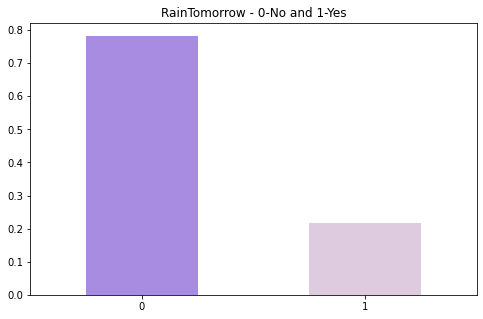

In [186]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
df.raintomorrow.value_counts(normalize = True).plot(kind='bar', color= ['mediumpurple','thistle'], alpha = 0.8, rot=0)
plt.title('RainTomorrow - 0-No and 1-Yes')
plt.show()

In [187]:
# Resample the training data with the RandomOversampler
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)


Counter(y_resampled)

Counter({1: 63164, 0: 63164})

##  Balanced Random Forest

#### For model validation, precision is more important to predict rainfall (as opposed to sensitivity) in order to accurately plan for droughts. Accuracy score is not an appropriate metrics for this model. We will use the following instead:

- Confusion Matrix
- Classification Report

In [ ]:
# Create a random forest classifier.

from imblearn.ensemble import BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=128, random_state=42) 

# Fitting the model
rf_model = rf_model.fit(X_resampled, y_resampled)

# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

# Calculated the balanced accuracy score
print('Accuracy Score : ', balanced_accuracy_score(y_test, y_pred))

In [ ]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

### Feature Importance

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
for importance, feat in sorted(zip(rf_model.feature_importances_, X.columns), reverse=True):
    print(f'{feat}: ({importance})')

In [ ]:
import matplotlib.pyplot as plt

important_features = pd.DataFrame({'Features': X.columns, 
                                   'Importance': rf_model.feature_importances_})

# print the dataframe
important_features.sort_values(by='Importance', ascending=False, inplace=True)

plt.rcParams['figure.figsize'] = 20,20
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

## Ploting Random Forest Results

In [ ]:
df_plt=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df_plt

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Gradient Boosting - For Comparison

#### This is just to compare results with random forest. Findings show that Gradient boosting performance is consistently lower than Random Forest

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_gb = GradientBoostingClassifier()
classifier_gb.fit(X_resampled, y_resampled)
y_gb=classifier_gb.predict(X_test_scaled)
print(classification_report_imbalanced(y_test, y_gb))
print('Accuracy Score : ',balanced_accuracy_score(y_test, y_gb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.80      0.77      0.86      0.79      0.62     15791
          1       0.52      0.77      0.80      0.62      0.79      0.62      4396

avg / total       0.84      0.79      0.78      0.81      0.79      0.62     20187

Accuracy Score :  0.7858278670156214


In [93]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, y_gb)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

Predicted 0  Predicted 1
Actual 0        12594         3197
Actual 1          993         3403